In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [22]:
import warnings
warnings.filterwarnings('ignore')

# Read the data

Function for reading ECG signals from a file

In [2]:
def read_X(filename):
    X = list()
    with open(filename) as f:
        while True:
            line = f.readline()
            if not line:
                break
            amplitudes = [int(x) for x in line.strip().split(',')]
            intervals = [int(x) for x in f.readline().strip().split(',')]
            
            f.readline() # skip an empty line
            X.append((amplitudes, intervals))
    return X

Read ECG signals of the train and test set

In [3]:
X_train_ecg = read_X('X.train.csv')
X_test_ecg = read_X('X.test.csv')
print(len(X_train_ecg), len(X_test_ecg))

900 903


Read labels of the train set

In [4]:
y_train = list()
for line in open('y.train.csv'):
    y_train.append(int(line))
print(len(y_train))

900


# Create trigram representation

Function for discretization of the ECG signals into 6 values (6 letters)

In [5]:
def discretize(X):
    discrete = list()
    for amps, ints in X:
        amps = array(amps).astype(float)
        ints = array(ints).astype(float)
        alphas = arctan(amps / ints)

        amps = diff(amps)
        ints = diff(ints)
        alphas = diff(alphas)

        s = list()
        for ind, r, t, a in zip(range(600), amps, ints, alphas):
            c = 'x'
            if r > 0 and t > 0 and a > 0:
                c = 'a'
            if r <= 0 and t <= 0 and a > 0:
                c = 'b'
            if r > 0 and t <= 0 and a > 0:
                c = 'c'
            if r <= 0 and t > 0 and a <= 0:
                c = 'd'
            if r > 0 and t > 0 and a <= 0:
                c = 'e'
            if r <= 0 and t <= 0 and a <= 0:
                c = 'f'
            if c == 'x':
                print('Very strange!!!', ind, r, t, a)
            s.append(c)

        discrete.append(s)
    return discrete

Apply it to our data. RuntimeWarning is fine, because of zeros in intervals. 

In [6]:
X_train_discrete = discretize(X_train_ecg)
X_test_discrete = discretize(X_test_ecg)
print(len(X_train_discrete), len(X_test_discrete))

900 903


/home/alexey/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


Function for counting trigrams and saving it in the numpy array format

In [7]:
from collections import defaultdict
from itertools import product

def vectorize(discrete):
    vectorized = list()
    for element in discrete:
        current = defaultdict(int)
        for j in range(597):
            current[tuple(element[j:j+3])] += 1

        vect = list()
        for a, b, c in product('abcdef', 'abcdef', 'abcdef'):
            vect.append(current[(a, b, c)])
        vectorized.append(vect)
    return array(vectorized).astype(float)

Create final train and test matrices

In [8]:
X_train = vectorize(X_train_discrete)
X_test = vectorize(X_test_discrete)
print(X_train.shape, X_test.shape)

(900, 216) (903, 216)


# Machine learning

Use 5-fold crossvalidation for finding optimal K in KNN

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_auc_score

params = {'n_neighbors': arange(1, 200, 5)}
grid_searcher = GridSearchCV(KNN(),\
                             params, cv=5, scoring='roc_auc', n_jobs=3)
grid_searcher.fit(X_train, y_train)

print(grid_searcher.best_score_)
print(grid_searcher.best_estimator_)

0.956093044733
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=36, p=2,
           weights='uniform')


Function for plotting the results

In [10]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(mean(elem.cv_validation_scores))
        stds.append(sqrt(var(elem.cv_validation_scores)))
    means = array(means)
    stds = array(stds)
    
    params = grid_searcher.param_grid
    
    figure(figsize=(8, 6))
    plot(params[param_name], means)
    fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    xlabel(param_name)
    ylabel('AUC')

Plot results

/home/alexey/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


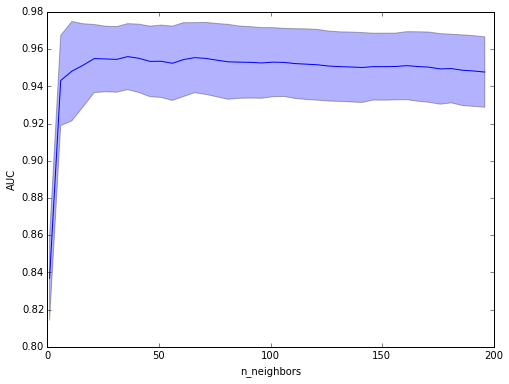

In [11]:
plot_quality(grid_searcher, 'n_neighbors')

Save the results in the proper format

In [12]:
clf = grid_searcher.best_estimator_.fit(X_train, y_train)
results = clf.predict_proba(X_test)[:, 1]
f = open('y.test.csv', 'w')
print('Id,Prediction', file=f)
for i, result in enumerate(results):
    print(str(i+1) + ',' + str(result), file=f)
f.close()

# My code

Отмасштабируем данные

In [13]:
from sklearn.preprocessing import scale
X_train_scaled = scale(X_train, with_mean = True, with_std=True, axis=0)
X_test_scaled = scale(X_test, with_mean = True, with_std=True, axis=0)

Визуализируем данные проекцией векторов на плоскость

In [14]:
c = ["blue", "red"]
colors = [c[y_train[i]] for i in range(len(y_train))]

/home/alexey/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


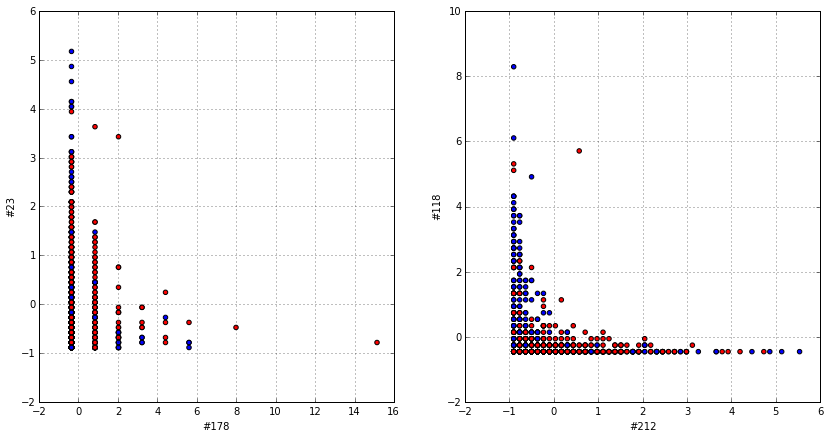

In [15]:
figure(figsize=(14,7))
U = X_train_scaled

for i in range(2):
    first = np.random.randint(6 * 6 * 6)
    second = np.random.randint(6 * 6 * 6)    
    subplot(1, 2, 1 + i), scatter(U[:, first], U[:, second], c=colors), \
        grid(True), xlabel('#{}'.format(first)), ylabel('#{}'.format(second))

В некоторых координатах цвета неплохо разделяются

Попробуем использовать взвешенную метрику Минковского. Веса определим как качество классификации на одном признаке.

In [16]:
def index_weight(index):
    params = {'n_neighbors': arange(1, 200, 5)}
    grid_searcher = GridSearchCV(KNN(weights='uniform', metric='minkowski', p=1),\
                             params, cv=5, scoring='roc_auc', n_jobs=3)
    grid_searcher.fit(X_train_scaled[:, [index]], y_train)
    return grid_searcher.best_score_

learned_weights = np.array([index_weight(index) for index in range(6*6*6)])

print(learned_weights)

[ 0.69689902  0.62280198  0.74945591  0.73716736  0.57884396  0.7613221
  0.56826018  0.64342486  0.51354378  0.67677982  0.56343745  0.67284651
  0.73162657  0.55460497  0.75398922  0.84539526  0.56206068  0.87558654
  0.78150513  0.68400054  0.74523014  0.62665168  0.51156031  0.64728717
  0.56252016  0.70203385  0.55968733  0.69263822  0.6508678   0.61392139
  0.81466335  0.51991813  0.76314944  0.8720484   0.66200631  0.78128206
  0.56165267  0.55077278  0.53891297  0.71454487  0.8259565   0.58651275
  0.75161741  0.72475865  0.7672072   0.68210097  0.78306072  0.63192675
  0.68334622  0.67515165  0.62121465  0.73914585  0.86617062  0.52560719
  0.6004084   0.62005497  0.56254012  0.50430786  0.64729495  0.58517452
  0.60427998  0.66672473  0.62387269  0.80485958  0.80693025  0.64107849
  0.61716829  0.63819103  0.51493693  0.55973818  0.61636695  0.58389837
  0.6699954   0.5529239   0.73962986  0.59469852  0.64387704  0.8166061
  0.51830017  0.69947688  0.62401654  0.50888406  0.6

Сдвинем все веса, обнулим слишком малые и немного растянем.

In [17]:
treshold = 0.6
metric_weights = pow(learned_weights - treshold, 2)
metric_weights[learned_weights < treshold] = 0

In [24]:
params = {'n_neighbors': arange(1, 50, )}
knn_grid_searcher = GridSearchCV(KNN(weights='distance', metric='wminkowski', p=1, w=metric_weights),\
                             params, cv=5, scoring='roc_auc', n_jobs=3)
knn_grid_searcher.fit(X_train_scaled, y_train)

print(knn_grid_searcher.best_score_)
print(knn_grid_searcher.best_estimator_)

0.965073539629
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='wminkowski',
           metric_params={'w': array([ 0.00939,  0.00052, ...,  0.     ,  0.01044])},
           n_jobs=1, n_neighbors=21, p=1, weights='distance')


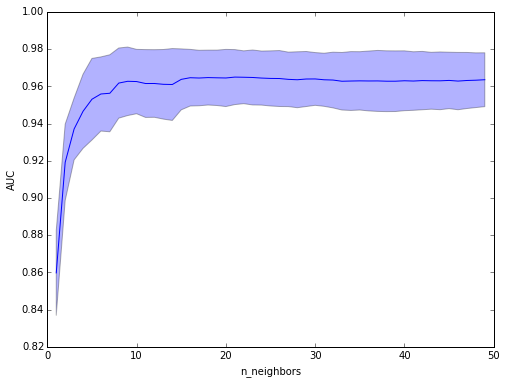

In [25]:
plot_quality(knn_grid_searcher, 'n_neighbors')

Результат: **kNN** даёт **0.96507**

Попробуем **DecisionTree**

In [26]:
def scaled_learn(clf, params):
    grid_searcher = GridSearchCV(clf,\
                             params, cv=5, scoring='roc_auc', n_jobs=3)
    grid_searcher.fit(X_train_scaled, y_train)

    print(grid_searcher.best_score_)
    print(grid_searcher.best_estimator_)
    
    return grid_searcher

In [28]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [35]:
%%time

params = {'max_depth': arange(1, 200, 1)}
dtc_grid_searcher = scaled_learn(DTC(), params)

0.891888007055
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
CPU times: user 1.83 s, sys: 33.2 ms, total: 1.86 s
Wall time: 18.3 s


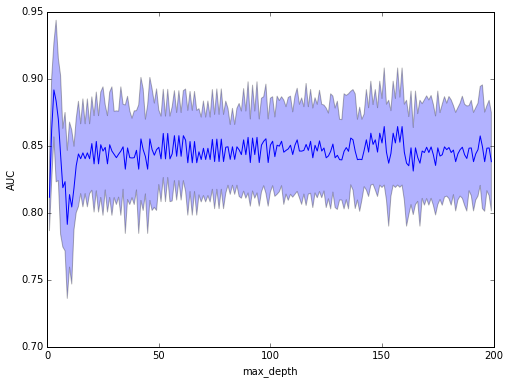

In [36]:
plot_quality(dtc_grid_searcher, 'max_depth')

Не очень. Добавим гиперпараметров

In [31]:
%%time

params = {'max_depth': arange(1, 200, 1), 'criterion': ['gini', 'entropy'], }
dtc_grid_searcher = scaled_learn(DTC(), params)

0.921165836139
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
CPU times: user 3.46 s, sys: 53.5 ms, total: 3.52 s
Wall time: 34.9 s


Получше. Ещё добавим

In [37]:
%%time

params = {'max_depth': arange(1, 20, 1), 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2', None] }
dtc_grid_searcher = scaled_learn(DTC(), params)

0.917610841751
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
CPU times: user 1.06 s, sys: 33.9 ms, total: 1.1 s
Wall time: 4.37 s


При многократных запусках видно, что от max_features не сильно влияет на ситуацию. Бывают результаты как хуже, так и лучше.

In [40]:
%%time

params = {'max_depth': arange(1, 10, 1)}
old_best = 0
for i in range(10):
    grid_searcher = scaled_learn(DTC(criterion='entropy'), params)
    if grid_searcher.best_score_ > old_best:
        dtc_grid_searcher = grid_searcher
        old_best = grid_searcher.best_score_
        
print(dtc_grid_searcher.best_score_)
print(dtc_grid_searcher.best_estimator_)

0.916827413821
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.912139572444
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.917610841751
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.91250337983
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nod

Результат: **DTC** даёт **0.92**

**SGD**

In [41]:
from sklearn.linear_model import SGDClassifier as SGD

SGD_params_list = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']

In [46]:
%%time

params = {'loss': SGD_params_list * 100, 'penalty': [None, 'l1', 'l2', 'elasticnet']}
sgd_grid_searcher = scaled_learn(SGD(warm_start=True), params)

0.947654182032
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_hinge', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=True)
CPU times: user 23.2 s, sys: 193 ms, total: 23.4 s
Wall time: 1min 19s


Результат: **SGD** даёт **0.95**

**RFC**

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
from sklearn import cross_validation
X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = cross_validation.train_test_split(X_train, y_train, test_size=0.5)

In [49]:
def get_score_list(X, y, clf):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict(X))
        rf_prediction = mean(predictions, axis=0)
        score.append(roc_auc_score(y, rf_prediction))
        if i % 100 == 0:
            print(score[-1])
    return score

In [50]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_score = get_score_list(X_train, y_train, clf)
    test_score = get_score_list(X_test, y_test, clf)
    if print_train:
        plot(train_score, label=prefix + ' train set error')
    plot(test_score, label=prefix + ' test set error')
    xlabel('n_estimators')
    ylabel('AUC')
    legend()

0.917990523969
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.856201587002
0.965260721708
0.963548554695
0.963926412243
0.965012752692
0.965260721708
0.964752975628
0.964989136596
0.964717551483
0.964705743435


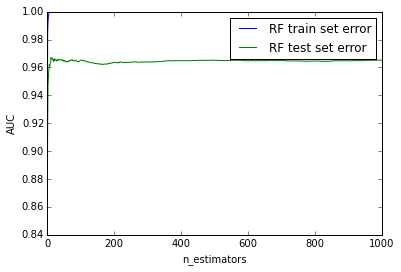

In [53]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, n_jobs=3),
               X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc,
               prefix='RF')

Достаточно хорошо. Немного не дотягивает до kNN. Положим n_estimators = 500

In [54]:
%%time

params = {'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2', None]}
rfc_grid_searcher = scaled_learn(RandomForestClassifier(n_estimators=500), params)

0.965033780129
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CPU times: user 12.9 s, sys: 33.3 ms, total: 12.9 s
Wall time: 1min 20s


Успех, мы догнали kNN.

Результат: **RFC** даёт **0.96503**

Смешаем **RFC** и **kNN**

In [55]:
def plot_quality_mix(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(mean(elem.cv_validation_scores))
        stds.append(sqrt(var(elem.cv_validation_scores)))
    means = array(means)
    stds = array(stds)
    
    params = grid_searcher.param_grid
    
    figure(figsize=(8, 6))
    x_axis = array(params[param_name])
    x_axis = x_axis[:, 0]
    plot(x_axis, means)
    fill_between(x_axis, \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    xlabel(param_name)
    ylabel('AUC')

In [56]:
from sklearn.ensemble import VotingClassifier as VC

In [57]:
rfc_est = rfc_grid_searcher.best_estimator_
knn_est = knn_grid_searcher.best_estimator_

mix_clf = VC(estimators=[('rfc', rfc_est), ('knn', knn_est)], voting='soft')

In [59]:
params = {'weights': [[alpha, 1 - alpha] for alpha in arange(0.01, 1.0, 0.03)]}
mix_searcher = scaled_learn(mix_clf, params)

0.968022333387
VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
          ...0.00052, ...,  0.     ,  0.01044])},
           n_jobs=1, n_neighbors=21, p=1, weights='distance'))],
         voting='soft', weights=[0.72999999999999998, 0.27000000000000002])


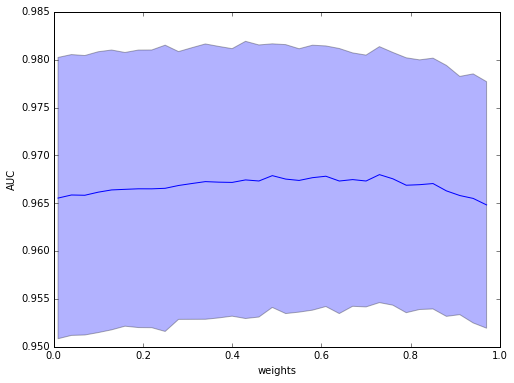

In [60]:
plot_quality_mix(mix_searcher, 'weights')

Не ахти выигрыш, но тоже неплохо.

In [61]:
clf = mix_searcher.best_estimator_.fit(X_train_scaled, y_train)

results = clf.predict_proba(X_test_scaled)[:, 1]
f = open('y.test.csv', 'w')
print('Id,Prediction', file=f)
for i, result in enumerate(results):
    print(str(i+1) + ',' + str(result), file=f)
f.close()